In [1]:
!pip install gensim
!pip install tensorflow
!pip install optuna
!pip install seaborn matplotlib
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from gensim.models import FastText
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import Constant
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv('/content/drive/MyDrive/competition/Court_Judgment/train.csv')
test = pd.read_csv('/content/drive/MyDrive/competition/Court_Judgment/test.csv')

## **Resampling**

In [5]:
(train['first_party_winner'] == 0).sum()

subset_0 = train[train["first_party_winner"] == 0]
subset_1 = train[train["first_party_winner"] == 1]

subset_1_downsampled = resample(subset_1,
                                replace=False,
                                n_samples=829,
                                random_state=42)

train = pd.concat([subset_0, subset_1_downsampled])

## **Data Preprocessing**

In [6]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
lemmatizer = WordNetLemmatizer()

In [8]:
def preprocess_text(text):
    # Convert NaNs to empty strings
    if pd.isnull(text):
        text = ''
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords.words('english')]
    return tokens

In [9]:
train['facts'] = train['facts'].apply(preprocess_text)
train['first_party'] = train['first_party'].apply(preprocess_text)
train['second_party'] = train['second_party'].apply(preprocess_text)

test['facts'] = test['facts'].apply(preprocess_text)
test['first_party'] = test['first_party'].apply(preprocess_text)
test['second_party'] = test['second_party'].apply(preprocess_text)

all_texts = train['facts'].tolist() + train['first_party'].tolist() + train['second_party'].tolist()

In [10]:
train['word_count'] = train['facts'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['facts'].apply(lambda x: len(str(x).split()))

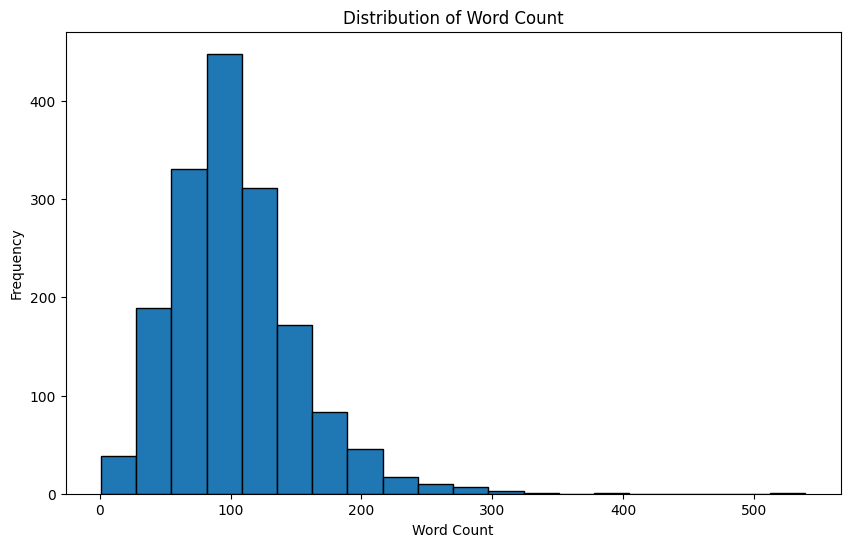

In [11]:
# Visualize the word count distribution
plt.figure(figsize=(10, 6))
plt.hist(train['word_count'], bins=20, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')
plt.show()

### **Using FastText**

In [12]:
# We train FastText model on all_texts
fasttext_model = FastText(sentences=all_texts, vector_size=200, window=5, min_count=1, workers=4)

# Define Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index

EMBEDDING_DIM = 200  # this should match the dimensionality of the FastText vectors

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in fasttext_model.wv:
        embedding_vector = fasttext_model.wv[word]
        embedding_matrix[i] = embedding_vector

# Load this into an Embedding layer
# Note that we set trainable=False to prevent the weights from being updated during training.
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            trainable=False)

In [13]:
def get_vector(model, texts):
    vectors = []
    for text in texts:
        text_vectors = []
        for word in text:
            if word in model.wv.key_to_index:
                text_vectors.append(model.wv.get_vector(word))
        if len(text_vectors) > 0:
            text_vector = np.mean(text_vectors, axis=0)
            vectors.append(text_vector)
        else:
            vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)

In [14]:
X_train_facts = get_vector(fasttext_model, train['facts'])
X_train_party1 = get_vector(fasttext_model, train['first_party'])
X_train_party2 = get_vector(fasttext_model, train['second_party'])
X_train = np.concatenate([X_train_party1, X_train_party2, X_train_facts], axis=1)
Y_train = train['first_party_winner']

X_test_facts = get_vector(fasttext_model, test['facts'])
X_test_party1 = get_vector(fasttext_model, test['first_party'])
X_test_party2 = get_vector(fasttext_model, test['second_party'])
X_test = np.concatenate([X_test_party1,X_test_party2, X_test_facts], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=123)

## **Define Model and Train**

In [15]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [16]:
import optuna
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
def objective(trial):
    # Define the search space for hyperparameters
    units = trial.suggest_int("units", 32, 128)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32])
    optimizer = Adam(learning_rate=learning_rate)

    # Define the model architecture
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(1, X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    # Train the model
    model.fit(X_train, Y_train, epochs=100, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=0, callbacks=[es])

    # Evaluate the model
    accuracy = model.evaluate(X_val, Y_val, verbose=0)[1]

    return accuracy

In [18]:
# Define the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and objective value
best_params = study.best_params
best_value = study.best_value
print("Best Parameters: ", best_params)
print("Best Value: ", best_value)

[I 2023-07-09 07:25:23,503] A new study created in memory with name: no-name-cfaa199b-4c8e-47b4-84c2-b43b464ecde9
<ipython-input-17-85f1acc3dace>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
<ipython-input-17-85f1acc3dace>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 24: early stopping


[I 2023-07-09 07:26:09,251] Trial 0 finished with value: 0.5813252925872803 and parameters: {'units': 100, 'learning_rate': 0.002438353840333428, 'dropout_rate': 0.2420497804406122, 'batch_size': 16}. Best is trial 0 with value: 0.5813252925872803.


Epoch 31: early stopping


[I 2023-07-09 07:26:43,672] Trial 1 finished with value: 0.5512048006057739 and parameters: {'units': 97, 'learning_rate': 0.00012139530574695453, 'dropout_rate': 0.10213586522064927, 'batch_size': 16}. Best is trial 0 with value: 0.5813252925872803.


Epoch 13: early stopping


[I 2023-07-09 07:27:01,984] Trial 2 finished with value: 0.47289156913757324 and parameters: {'units': 102, 'learning_rate': 0.01473413234473286, 'dropout_rate': 0.0878003038125223, 'batch_size': 16}. Best is trial 0 with value: 0.5813252925872803.


Epoch 41: early stopping


[I 2023-07-09 07:28:28,240] Trial 3 finished with value: 0.5602409839630127 and parameters: {'units': 117, 'learning_rate': 3.39913514083648e-05, 'dropout_rate': 0.2240671355836636, 'batch_size': 16}. Best is trial 0 with value: 0.5813252925872803.


Epoch 49: early stopping


[I 2023-07-09 07:29:04,295] Trial 4 finished with value: 0.5783132314682007 and parameters: {'units': 113, 'learning_rate': 5.003611003896034e-05, 'dropout_rate': 0.08958926631659742, 'batch_size': 32}. Best is trial 0 with value: 0.5813252925872803.


Epoch 26: early stopping


[I 2023-07-09 07:29:25,068] Trial 5 finished with value: 0.5873494148254395 and parameters: {'units': 110, 'learning_rate': 0.0002952169933854213, 'dropout_rate': 0.35406591450739894, 'batch_size': 32}. Best is trial 5 with value: 0.5873494148254395.


Epoch 25: early stopping


[I 2023-07-09 07:29:53,325] Trial 6 finished with value: 0.5722891688346863 and parameters: {'units': 103, 'learning_rate': 0.000493102122697772, 'dropout_rate': 0.07244238592373942, 'batch_size': 16}. Best is trial 5 with value: 0.5873494148254395.


Epoch 42: early stopping


[I 2023-07-09 07:30:22,063] Trial 7 finished with value: 0.5662650465965271 and parameters: {'units': 93, 'learning_rate': 4.0130943981058344e-05, 'dropout_rate': 0.07970323258238271, 'batch_size': 32}. Best is trial 5 with value: 0.5873494148254395.


Epoch 19: early stopping


[I 2023-07-09 07:30:37,928] Trial 8 finished with value: 0.5271084308624268 and parameters: {'units': 101, 'learning_rate': 0.019122006995368732, 'dropout_rate': 0.04971840868619176, 'batch_size': 32}. Best is trial 5 with value: 0.5873494148254395.


Epoch 17: early stopping


[I 2023-07-09 07:30:58,353] Trial 9 finished with value: 0.5813252925872803 and parameters: {'units': 72, 'learning_rate': 0.0004931454323633574, 'dropout_rate': 0.1053041638207825, 'batch_size': 16}. Best is trial 5 with value: 0.5873494148254395.


Epoch 19: early stopping


[I 2023-07-09 07:31:12,776] Trial 10 finished with value: 0.5271084308624268 and parameters: {'units': 38, 'learning_rate': 0.09473988964349599, 'dropout_rate': 0.4677571838647214, 'batch_size': 32}. Best is trial 5 with value: 0.5873494148254395.


Epoch 27: early stopping


[I 2023-07-09 07:31:37,594] Trial 11 finished with value: 0.5783132314682007 and parameters: {'units': 128, 'learning_rate': 0.0019354069738809173, 'dropout_rate': 0.32139699995223003, 'batch_size': 32}. Best is trial 5 with value: 0.5873494148254395.


Epoch 55: early stopping


[I 2023-07-09 07:32:08,740] Trial 12 finished with value: 0.5542168617248535 and parameters: {'units': 77, 'learning_rate': 0.0019833465823940258, 'dropout_rate': 0.3190145516806072, 'batch_size': 32}. Best is trial 5 with value: 0.5873494148254395.


Epoch 91: early stopping


[I 2023-07-09 07:33:36,119] Trial 13 finished with value: 0.5813252925872803 and parameters: {'units': 65, 'learning_rate': 1.2153711014540209e-05, 'dropout_rate': 0.22496943837359493, 'batch_size': 16}. Best is trial 5 with value: 0.5873494148254395.


Epoch 33: early stopping


[I 2023-07-09 07:34:01,353] Trial 14 finished with value: 0.5903614163398743 and parameters: {'units': 57, 'learning_rate': 0.00023786264295899223, 'dropout_rate': 0.40065557805175267, 'batch_size': 16}. Best is trial 14 with value: 0.5903614163398743.


Epoch 25: early stopping


[I 2023-07-09 07:34:15,006] Trial 15 finished with value: 0.5692771077156067 and parameters: {'units': 51, 'learning_rate': 0.0002200738832059002, 'dropout_rate': 0.4362332845268719, 'batch_size': 32}. Best is trial 14 with value: 0.5903614163398743.


Epoch 43: early stopping


[I 2023-07-09 07:34:59,802] Trial 16 finished with value: 0.5692771077156067 and parameters: {'units': 59, 'learning_rate': 0.00015753653725781707, 'dropout_rate': 0.40437583692737905, 'batch_size': 16}. Best is trial 14 with value: 0.5903614163398743.


Epoch 35: early stopping


[I 2023-07-09 07:35:24,219] Trial 17 finished with value: 0.5692771077156067 and parameters: {'units': 32, 'learning_rate': 0.0004942309164900513, 'dropout_rate': 0.3781162370895432, 'batch_size': 32}. Best is trial 14 with value: 0.5903614163398743.


Epoch 32: early stopping


[I 2023-07-09 07:35:48,643] Trial 18 finished with value: 0.5903614163398743 and parameters: {'units': 86, 'learning_rate': 0.00013138174599166974, 'dropout_rate': 0.4811698538786245, 'batch_size': 32}. Best is trial 14 with value: 0.5903614163398743.


Epoch 41: early stopping


[I 2023-07-09 07:36:33,446] Trial 19 finished with value: 0.5602409839630127 and parameters: {'units': 85, 'learning_rate': 9.988788209954478e-05, 'dropout_rate': 0.4851889090168376, 'batch_size': 16}. Best is trial 14 with value: 0.5903614163398743.
[I 2023-07-09 07:37:59,215] Trial 20 finished with value: 0.5602409839630127 and parameters: {'units': 49, 'learning_rate': 1.2371812590165834e-05, 'dropout_rate': 0.49509974372511933, 'batch_size': 16}. Best is trial 14 with value: 0.5903614163398743.


Epoch 30: early stopping


[I 2023-07-09 07:38:25,623] Trial 21 finished with value: 0.5662650465965271 and parameters: {'units': 82, 'learning_rate': 0.0002528267975405978, 'dropout_rate': 0.4301152708002552, 'batch_size': 32}. Best is trial 14 with value: 0.5903614163398743.


Epoch 37: early stopping


[I 2023-07-09 07:38:51,960] Trial 22 finished with value: 0.5662650465965271 and parameters: {'units': 87, 'learning_rate': 7.949093826019476e-05, 'dropout_rate': 0.36423043204548144, 'batch_size': 32}. Best is trial 14 with value: 0.5903614163398743.


Epoch 33: early stopping


[I 2023-07-09 07:39:08,908] Trial 23 finished with value: 0.5662650465965271 and parameters: {'units': 69, 'learning_rate': 0.0007469193734157734, 'dropout_rate': 0.43100456428911155, 'batch_size': 32}. Best is trial 14 with value: 0.5903614163398743.


Epoch 28: early stopping


[I 2023-07-09 07:39:34,139] Trial 24 finished with value: 0.5753012299537659 and parameters: {'units': 112, 'learning_rate': 0.00027994059705577185, 'dropout_rate': 0.45900870812221417, 'batch_size': 32}. Best is trial 14 with value: 0.5903614163398743.


Epoch 48: early stopping


[I 2023-07-09 07:39:55,309] Trial 25 finished with value: 0.5813252925872803 and parameters: {'units': 57, 'learning_rate': 7.928476561228758e-05, 'dropout_rate': 0.3897137414145664, 'batch_size': 32}. Best is trial 14 with value: 0.5903614163398743.


Epoch 41: early stopping


[I 2023-07-09 07:40:21,731] Trial 26 finished with value: 0.5873494148254395 and parameters: {'units': 91, 'learning_rate': 0.0011053246062707029, 'dropout_rate': 0.4964469628506277, 'batch_size': 32}. Best is trial 14 with value: 0.5903614163398743.


Epoch 56: early stopping


[I 2023-07-09 07:40:47,363] Trial 27 finished with value: 0.5753012299537659 and parameters: {'units': 45, 'learning_rate': 0.00023228883396700446, 'dropout_rate': 0.34211367301682494, 'batch_size': 32}. Best is trial 14 with value: 0.5903614163398743.


Epoch 56: early stopping


[I 2023-07-09 07:41:37,440] Trial 28 finished with value: 0.5662650465965271 and parameters: {'units': 121, 'learning_rate': 2.282720556806507e-05, 'dropout_rate': 0.28471177254233954, 'batch_size': 16}. Best is trial 14 with value: 0.5903614163398743.


Epoch 26: early stopping


[I 2023-07-09 07:41:57,276] Trial 29 finished with value: 0.5843373537063599 and parameters: {'units': 77, 'learning_rate': 0.0001358130690169562, 'dropout_rate': 0.40478152858482763, 'batch_size': 16}. Best is trial 14 with value: 0.5903614163398743.


Epoch 37: early stopping


[I 2023-07-09 07:42:23,055] Trial 30 finished with value: 0.5753012299537659 and parameters: {'units': 106, 'learning_rate': 6.545473803143398e-05, 'dropout_rate': 0.4567344504168422, 'batch_size': 32}. Best is trial 14 with value: 0.5903614163398743.


Epoch 27: early stopping


[I 2023-07-09 07:42:47,291] Trial 31 finished with value: 0.5933734774589539 and parameters: {'units': 90, 'learning_rate': 0.0011638445051128984, 'dropout_rate': 0.49516644223032624, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 29: early stopping


[I 2023-07-09 07:43:03,497] Trial 32 finished with value: 0.5542168617248535 and parameters: {'units': 93, 'learning_rate': 0.0010370998526775296, 'dropout_rate': 0.4256968272160809, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 49: early stopping


[I 2023-07-09 07:43:24,130] Trial 33 finished with value: 0.5662650465965271 and parameters: {'units': 63, 'learning_rate': 0.0001377427709998296, 'dropout_rate': 0.46807953424548143, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 18: early stopping


[I 2023-07-09 07:43:39,882] Trial 34 finished with value: 0.5361445546150208 and parameters: {'units': 109, 'learning_rate': 0.003775427613294234, 'dropout_rate': 0.40075962644964025, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 29: early stopping


[I 2023-07-09 07:44:04,612] Trial 35 finished with value: 0.5632529854774475 and parameters: {'units': 97, 'learning_rate': 0.0003647395385736695, 'dropout_rate': 0.4979040813041586, 'batch_size': 16}. Best is trial 31 with value: 0.5933734774589539.


Epoch 38: early stopping


[I 2023-07-09 07:44:23,041] Trial 36 finished with value: 0.5692771077156067 and parameters: {'units': 75, 'learning_rate': 0.00020029021874381077, 'dropout_rate': 0.4478474251411332, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 15: early stopping


[I 2023-07-09 07:44:48,224] Trial 37 finished with value: 0.5632529854774475 and parameters: {'units': 119, 'learning_rate': 0.0006781185068111903, 'dropout_rate': 0.36128551018945926, 'batch_size': 16}. Best is trial 31 with value: 0.5933734774589539.


Epoch 53: early stopping


[I 2023-07-09 07:45:13,678] Trial 38 finished with value: 0.5662650465965271 and parameters: {'units': 88, 'learning_rate': 5.315073506962328e-05, 'dropout_rate': 0.41464364021832006, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 27: early stopping


[I 2023-07-09 07:45:39,187] Trial 39 finished with value: 0.5692771077156067 and parameters: {'units': 97, 'learning_rate': 0.00010973739654492263, 'dropout_rate': 0.4511872087411154, 'batch_size': 16}. Best is trial 31 with value: 0.5933734774589539.


Epoch 63: early stopping


[I 2023-07-09 07:46:11,670] Trial 40 finished with value: 0.5843373537063599 and parameters: {'units': 105, 'learning_rate': 3.364795737466949e-05, 'dropout_rate': 0.46897491031704525, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 35: early stopping


[I 2023-07-09 07:46:29,751] Trial 41 finished with value: 0.5421686768531799 and parameters: {'units': 92, 'learning_rate': 0.0011951873984243798, 'dropout_rate': 0.49228171824433686, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 32: early stopping


[I 2023-07-09 07:46:46,081] Trial 42 finished with value: 0.5632529854774475 and parameters: {'units': 80, 'learning_rate': 0.00036772391794316725, 'dropout_rate': 0.46755130531203926, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 31: early stopping


[I 2023-07-09 07:47:12,333] Trial 43 finished with value: 0.5903614163398743 and parameters: {'units': 90, 'learning_rate': 0.0014506520734604961, 'dropout_rate': 0.42497986713417485, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 14: early stopping


[I 2023-07-09 07:47:27,483] Trial 44 finished with value: 0.5843373537063599 and parameters: {'units': 99, 'learning_rate': 0.004456565083232673, 'dropout_rate': 0.3865283552787879, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 46: early stopping


[I 2023-07-09 07:47:54,365] Trial 45 finished with value: 0.5572289228439331 and parameters: {'units': 125, 'learning_rate': 0.0006521173016686021, 'dropout_rate': 0.41540031337614836, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 26: early stopping


[I 2023-07-09 07:48:08,084] Trial 46 finished with value: 0.5572289228439331 and parameters: {'units': 70, 'learning_rate': 0.00034688949909233866, 'dropout_rate': 0.4320647051695928, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 33: early stopping


[I 2023-07-09 07:48:53,886] Trial 47 finished with value: 0.5240963697433472 and parameters: {'units': 115, 'learning_rate': 0.001412057480137681, 'dropout_rate': 0.376072406396032, 'batch_size': 16}. Best is trial 31 with value: 0.5933734774589539.


Epoch 25: early stopping


[I 2023-07-09 07:49:19,253] Trial 48 finished with value: 0.5843373537063599 and parameters: {'units': 84, 'learning_rate': 0.00016212299036497124, 'dropout_rate': 0.44227635216365224, 'batch_size': 32}. Best is trial 31 with value: 0.5933734774589539.


Epoch 44: early stopping


[I 2023-07-09 07:49:43,496] Trial 49 finished with value: 0.6114457845687866 and parameters: {'units': 80, 'learning_rate': 0.0005228570449480574, 'dropout_rate': 0.4759662467551873, 'batch_size': 32}. Best is trial 49 with value: 0.6114457845687866.


Best Parameters:  {'units': 80, 'learning_rate': 0.0005228570449480574, 'dropout_rate': 0.4759662467551873, 'batch_size': 32}
Best Value:  0.6114457845687866


In [19]:
from sklearn.metrics import roc_curve

model = Sequential()
model.add(LSTM(best_params['units'], return_sequences=True, input_shape=(1, X_train.shape[2])))
model.add(Dropout(best_params['dropout_rate']))
model.add(LSTM(best_params['units']))
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=best_params['batch_size'], validation_data=(X_val, Y_val), callbacks=[es])
#model.fit(X_train, Y_train, epochs=100, batch_size=best_params['batch_size'], validation_data=(X_val, Y_val))

vector_size = X_train.shape[2]  # Assuming X_train is already defined
X_test = X_test.reshape((X_test.shape[0], 1, vector_size))

# predicting probabilities instead of classes
pred_probs = model.predict(X_test)

# get the false positive rate, true positive rate, and all thresholds
fpr, tpr, thresholds = roc_curve(Y_val, model.predict(X_val).ravel())

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)

print('Best Threshold=%f' % thresholds[ix])

Epoch 1/100
42/42 [==============================] - 5s 27ms/step - loss: 0.6927 - accuracy: 0.5249 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 2/100
42/42 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5234 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 3/100
42/42 [==============================] - 0s 8ms/step - loss: 0.6870 - accuracy: 0.5279 - val_loss: 0.6850 - val_accuracy: 0.5663
Epoch 4/100
42/42 [==============================] - 0s 9ms/step - loss: 0.6898 - accuracy: 0.5279 - val_loss: 0.6838 - val_accuracy: 0.5904
Epoch 5/100
42/42 [==============================] - 0s 8ms/step - loss: 0.6853 - accuracy: 0.5347 - val_loss: 0.6862 - val_accuracy: 0.5271
Epoch 6/100
42/42 [==============================] - 0s 8ms/step - loss: 0.6863 - accuracy: 0.5513 - val_loss: 0.6831 - val_accuracy: 0.5843
Epoch 7/100
42/42 [==============================] - 0s 9ms/step - loss: 0.6898 - accuracy: 0.5339 - val_loss: 0.6881 - val_accuracy: 0.5120
Epoch 8/100


11/11 [==============================] - 0s 2ms/step


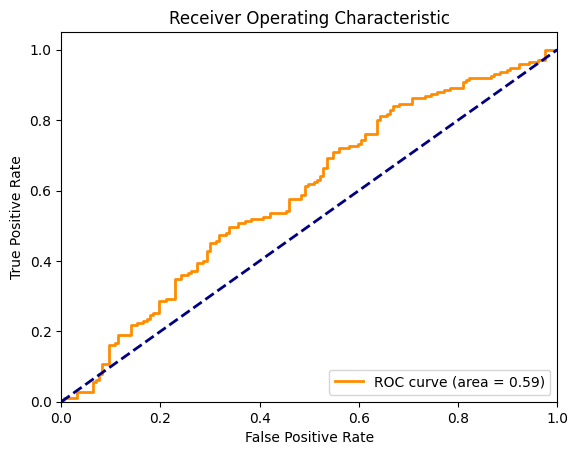

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(Y_val, model.predict(X_val).ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## **Inference & Submission**

In [21]:
predictions = (pred_probs > thresholds[ix]).astype(int).flatten()

submit = pd.read_csv('/content/drive/MyDrive/competition/Court_Judgment/sample_submission.csv')

submit['first_party_winner'] = predictions
submit.to_csv('/content/drive/MyDrive/competition/Court_Judgment/baseline_submit_best.csv', index=False)
print('Done')

Done
